**Import Libraries**

In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

**Load data**

In [17]:
# Load dataset
data_path = "/content/Phishing Data.csv"
df = pd.read_csv(data_path)

# Overview of our data
print("Dataset Info:")
print(f"Shape : {df.shape}")
print(f"Columns: {df.columns}")
print("some rows:")
print(df.head())
print("\nSummary stats:")
print(df.describe())

Dataset Info:
Shape : (2456, 31)
Columns: Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')
some rows:
   having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                  1           1                   0                 0   
1                  0           1                   0                 0   
2                  0           0                   0                 0   
3                  0           0             

**Check Data class**

In [18]:
# Check class balance for target variable 'Result'
target = 'Result'
if target in df.columns:
    counts = df[target].value_counts()
    print(f"Class Distribution: Legitimate (0): {counts[0]}, Phishing (1): {counts[1]}")
    imbalance_ratio = counts.min() / counts.max()
    if imbalance_ratio < 0.8:
        print("Imbalanced dataset detected. Will apply SMOTE later.")
    else:
        print("Dataset is nearly balanced. No need to apply any data balancing techniques.")
else:
    print(f"Error: Target column '{target}' not found.")

Class Distribution: Legitimate (0): 1362, Phishing (1): 1094
Dataset is nearly balanced. No need to apply any data balancing techniques.


**EDA: One of the most important steps for our modeling and the most important way to extract insights and useful information from our data**

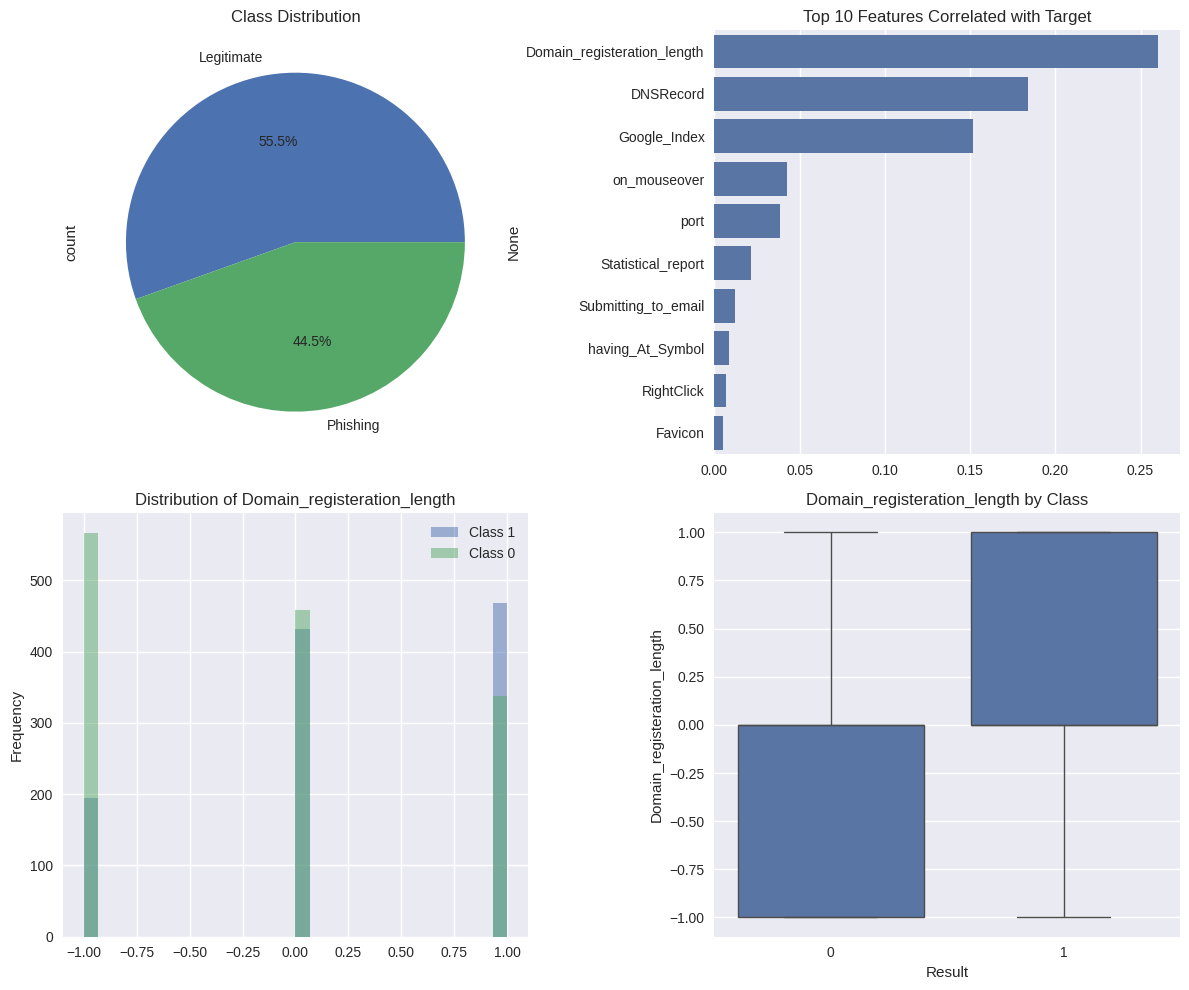

In [19]:
# Some quick plots to check data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

# Class distribution
plt.subplot(2, 2, 1)
df[target].value_counts().plot(kind='pie', labels=['Legitimate', 'Phishing'], autopct='%1.1f%%')
plt.title("Class Distribution")

# Correlation with target
plt.subplot(2, 2, 2)
corr = df.corr()[target].drop(target).sort_values(ascending=False)
sns.barplot(x=corr.values[:10], y=corr.index[:10])
plt.title("Top 10 Features Correlated with Target")

# Histogram of most important feature
plt.subplot(2, 2, 3)
top_feature = corr.index[0]
for c in df[target].unique():
    df[df[target] == c][top_feature].plot(kind='hist', bins=30, alpha=0.5, label=f'Class {c}')
plt.legend()
plt.title(f"Distribution of {top_feature}")

# Boxplot for same feature
plt.subplot(2, 2, 4)
sns.boxplot(x=target, y=top_feature, data=df)
plt.title(f"{top_feature} by Class")

plt.tight_layout()
plt.show()


**Data Insights**

There is a fair amount of balance in the dataset.

 The most effective feature for identifying phishing websites is domain_registration_length.

 Strong signals are also provided by Google_Index and DNSRecord.

 Certain features (such as having_At_Symbol, Favicon, and RightClick) might not be very useful and might be dropped.

 Given the strong, non-linear separation from top features, a tree-based model like Random Forest would probably do well.

**feature importance**

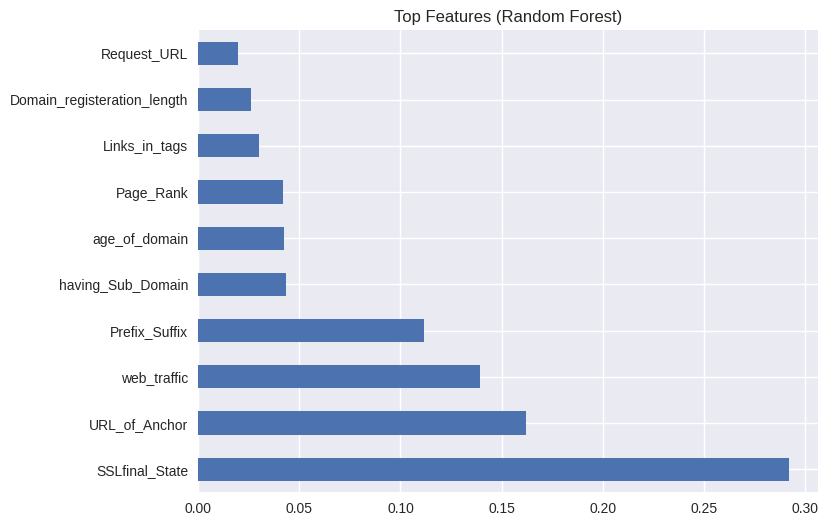

SSLfinal_State                 0.291799
URL_of_Anchor                  0.162267
web_traffic                    0.139478
Prefix_Suffix                  0.111671
having_Sub_Domain              0.043605
age_of_domain                  0.042341
Page_Rank                      0.042117
Links_in_tags                  0.029931
Domain_registeration_length    0.026379
Request_URL                    0.019656
dtype: float64


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train a quick Random Forest
X = df.drop(columns=[target])
y = df[target]

rf = RandomForestClassifier()
rf.fit(X, y)

# Get feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_feats = importances.sort_values(ascending=False)[:10]

# Plot
top_feats.plot(kind='barh', figsize=(8,6))
plt.title("Top Features (Random Forest)")
plt.show()

print(top_feats)


**Insights get from top 10 feature importance by random forest**
About half of the model's predictive power can be explained by SSLfinal_State + URL_of_Anchor alone.

 Another 20% or so is made up of domain-based characteristics, such as age, registration length, subdomains, and prefix-suffix.

 Additional signal is added by behavioral/traffic-based features (web traffic, page rank).

 This demonstrates how closely domain/SSL quality and link structure are related to phishing detection.

**Data Preprocessing**

In [21]:
# Features and target
X = df.drop(target, axis=1)
y = df[target]

# Fill NA with median (numeric only)
for col in X.select_dtypes(include='number').columns:
    X[col].fillna(X[col].median(), inplace=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Check imbalance but we don't need because our dataset is nearly balanced so we commented this code

# ratio = y_train.value_counts().min() / y_train.value_counts().max()
# if ratio < 0.8:
#     sm = SMOTE(random_state=42)
#     X_train, y_train = sm.fit_resample(X_train, y_train)
#     print("SMOTE applied:", X_train.shape)

**Train Models**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Try a few models
models = [
    ("LogReg", LogisticRegression(max_iter=1000, random_state=42)),
    ("RandomForest", RandomForestClassifier(random_state=42)),
    ("XGB", xgb.XGBClassifier(random_state=42, eval_metric="logloss")),
    ("SVM", SVC(probability=True, random_state=42))
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, clf in models:
    # CV
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="f1")
    print(name, "CV F1:", scores.mean().round(3))

    # Train and predict
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    probs = clf.predict_proba(X_test)[:,1]

    results[name] = {
        "acc": accuracy_score(y_test, preds),
        "prec": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "auc": roc_auc_score(y_test, probs)
    }
    print(name, results[name])


LogReg CV F1: 0.933
LogReg {'acc': 0.9288617886178862, 'prec': 0.9259259259259259, 'recall': 0.91324200913242, 'f1': 0.9195402298850575, 'auc': np.float64(0.9845869503403749)}
RandomForest CV F1: 0.965
RandomForest {'acc': 0.9654471544715447, 'prec': 0.9590909090909091, 'recall': 0.9634703196347032, 'f1': 0.9612756264236902, 'auc': np.float64(0.993819726696439)}
XGB CV F1: 0.966
XGB {'acc': 0.959349593495935, 'prec': 0.9422222222222222, 'recall': 0.9680365296803652, 'f1': 0.954954954954955, 'auc': np.float64(0.9911435596367103)}
SVM CV F1: 0.953
SVM {'acc': 0.9369918699186992, 'prec': 0.9392523364485982, 'recall': 0.9178082191780822, 'f1': 0.9284064665127021, 'auc': np.float64(0.981074481074481)}



Cross-Validation (CV) F1-Scores

Logistic Regression → 0.933

Random Forest → 0.965

XGBoost → 0.966

SVM → 0.953


**Test Set Performance**

| Model               | Accuracy | Precision | Recall | F1-Score | AUC   |
| ------------------- | -------- | --------- | ------ | -------- | ----- |
| Logistic Regression | 0.929    | 0.926     | 0.913  | 0.920    | 0.985 |
| Random Forest       | 0.965    | 0.959     | 0.963  | 0.961    | 0.994 |
| XGBoost             | 0.959    | 0.942     | 0.968  | 0.955    | 0.991 |
| SVM                 | 0.937    | 0.939     | 0.918  | 0.928    | 0.981 |


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Random Forest tuning
rf_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    'min_samples_split': [2, 5]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_grid, cv=3, scoring="f1", n_jobs=-1)
rf.fit(X_train, y_train)
print("Best RF:", rf.best_params_)

# XGBoost tuning
xgb_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.1, 0.2]
}
xg = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric="logloss"), xgb_grid, cv=3, scoring="f1", n_jobs=-1)
xg.fit(X_train, y_train)
print("Best XGB:", xg.best_params_)

# Evaluate on test
for name, model in [("RF Tuned", rf.best_estimator_), ("XGB Tuned", xg.best_estimator_)]:
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]
    print(name,
          "Acc:", round(accuracy_score(y_test, preds),3),
          "Prec:", round(precision_score(y_test, preds),3),
          "Rec:", round(recall_score(y_test, preds),3),
          "F1:", round(f1_score(y_test, preds),3),
          "AUC:", round(roc_auc_score(y_test, probs),3))


Best RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best XGB: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
RF Tuned Acc: 0.965 Prec: 0.959 Rec: 0.963 F1: 0.961 AUC: 0.994
XGB Tuned Acc: 0.941 Prec: 0.936 Rec: 0.932 F1: 0.934 AUC: 0.989


**Important Points**

On nearly all metrics (Acc + F1 + Recall), Random Forest outperforms XGBoost.

 AUC > 0.98 for both models indicates excellent generalization and strong separability.

 Random Forest is safer if we want the highest recall (catching positives).

 Since XGBoost is shallower, it might be the better choice if we want a lighter model and faster inference.

In [24]:
#Store results in dictionary
results = {}

for name, model in [("Random Forest (Tuned)", rf.best_estimator_),
                    ("XGBoost (Tuned)", xg.best_estimator_)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "model": model,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

#Summarize results
results_df = pd.DataFrame({
    name: {
        "Accuracy": results[name]["accuracy"],
        "Precision": results[name]["precision"],
        "Recall": results[name]["recall"],
        "F1-Score": results[name]["f1"],
        "AUC-ROC": results[name]["auc"]
    } for name in results
}).T

print("Model Summary:")
print(results_df.round(4))

#best model by F1-Score
best_model_name = results_df["F1-Score"].idxmax()
best_model = results[best_model_name]["model"]

print(f"\nBest model: {best_model_name} "
      f"(F1-Score: {results[best_model_name]['f1']:.4f})")

#evaluation of best model
y_pred_best = results[best_model_name]["y_pred"]

print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=["Legitimate", "Phishing"]))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\n🔻 Confusion Matrix:")
print(cm)


Model Summary:
                       Accuracy  Precision  Recall  F1-Score  AUC-ROC
Random Forest (Tuned)    0.9654     0.9591  0.9635    0.9613   0.9943
XGBoost (Tuned)          0.9411     0.9358  0.9315    0.9336   0.9895

Best model: Random Forest (Tuned) (F1-Score: 0.9613)
Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.97      0.97      0.97       273
    Phishing       0.96      0.96      0.96       219

    accuracy                           0.97       492
   macro avg       0.96      0.97      0.97       492
weighted avg       0.97      0.97      0.97       492


🔻 Confusion Matrix:
[[264   9]
 [  8 211]]


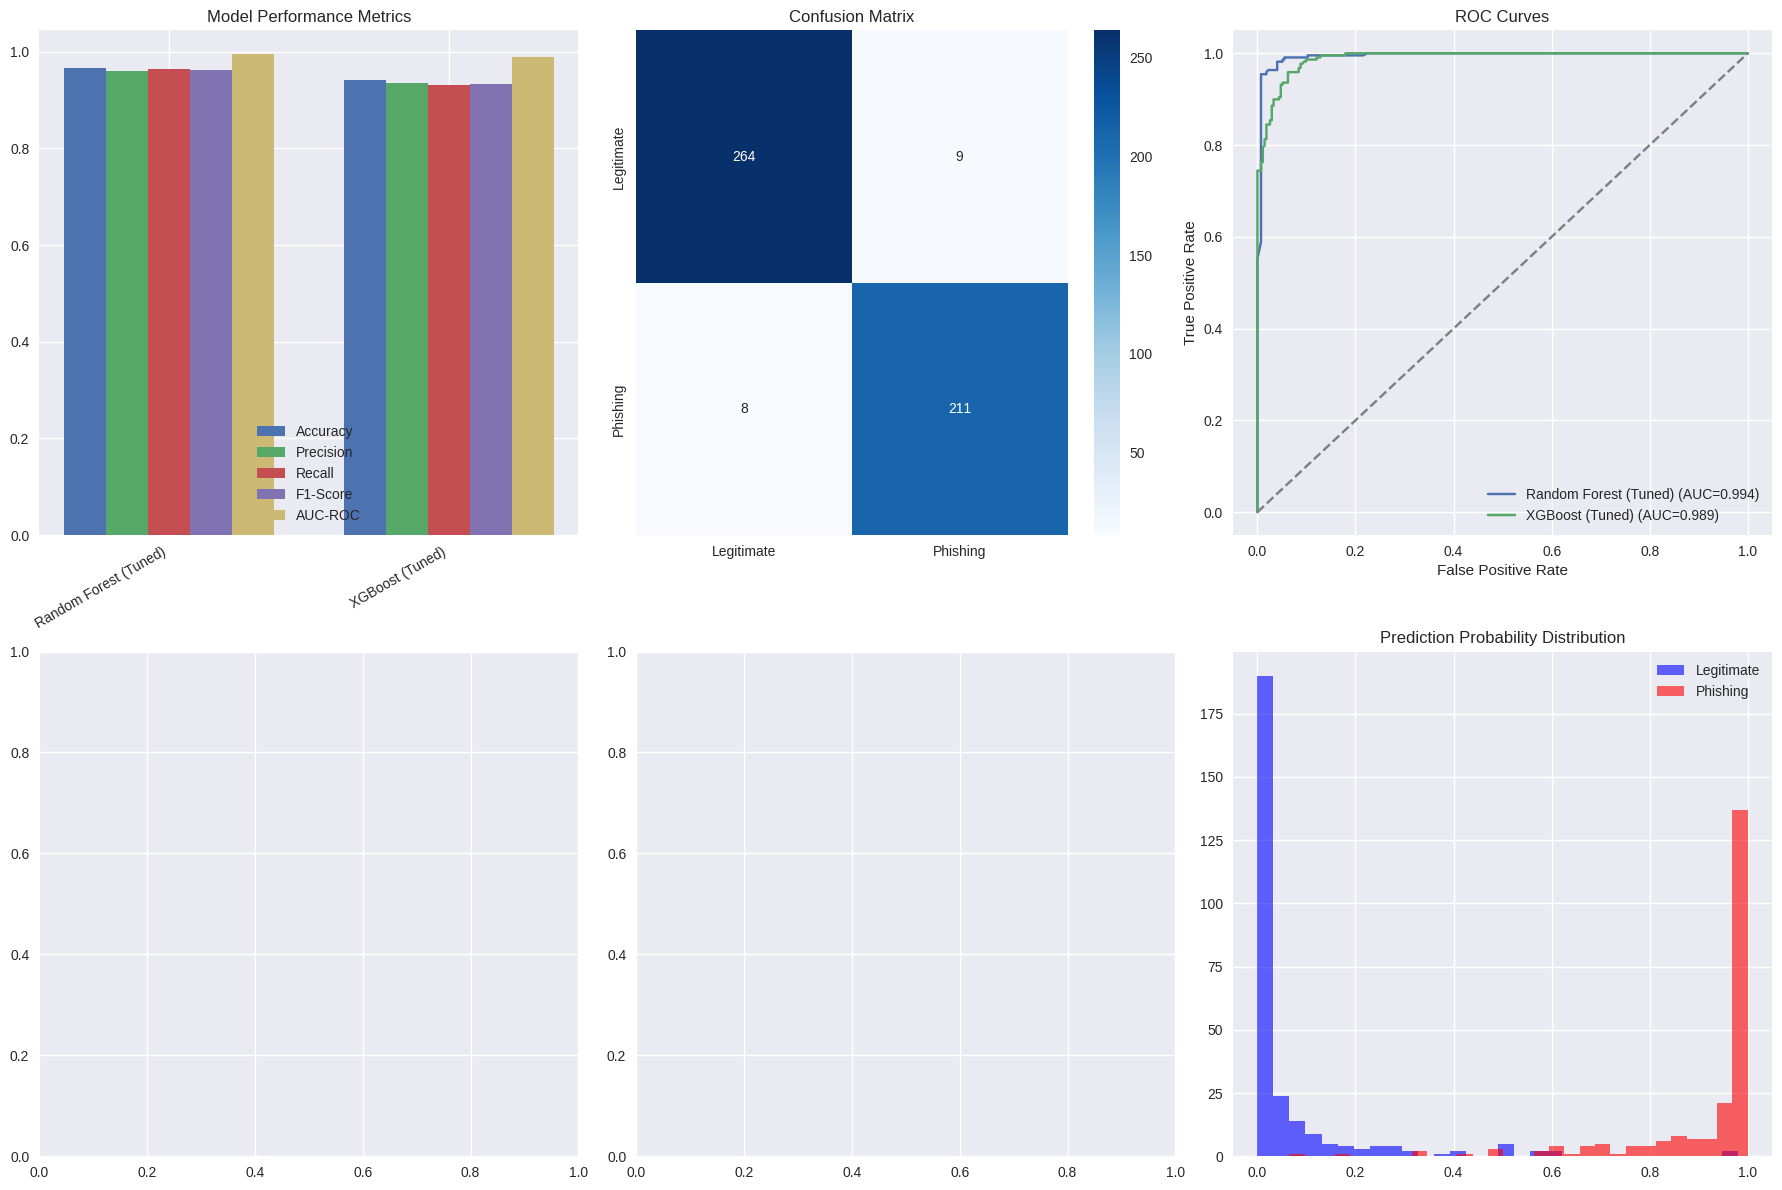

In [25]:
#Setting up the figure for all our plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Bar plot  metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]
x = np.arange(len(results_df))
bar_width = 0.15

for i, metric in enumerate(metrics):
    axes[0, 0].bar(x + i*bar_width, results_df[metric], width=bar_width, label=metric)

axes[0, 0].set_title("Model Performance Metrics")
axes[0, 0].set_xticks(x + bar_width*2)
axes[0, 0].set_xticklabels(results_df.index, rotation=30, ha="right")
axes[0, 0].legend()

# Confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legitimate", "Phishing"],
    yticklabels=["Legitimate", "Phishing"],
    ax=axes[0, 1]
)
axes[0, 1].set_title("Confusion Matrix")

# Plotting ROC curves
for model_name in results:
    if 'y_proba' in results[model_name]:
        fpr, tpr, _ = roc_curve(y_test, results[model_name]["y_proba"])
        axes[0, 2].plot(fpr, tpr, label=f"{model_name} (AUC={results[model_name]['auc']:.3f})")

axes[0, 2].plot([0, 1], [0, 1], "--", color="gray")
axes[0, 2].set_title("ROC Curves")
axes[0, 2].set_xlabel("False Positive Rate")
axes[0, 2].set_ylabel("True Positive Rate")
axes[0, 2].legend()


# Probability distributions of predictions of best model
if 'y_proba' in results[best_model_name]:
    probs = results[best_model_name]["y_proba"]
    axes[1, 2].hist(probs[y_test==0], bins=30, alpha=0.6, color="blue", label="Legitimate")
    axes[1, 2].hist(probs[y_test==1], bins=30, alpha=0.6, color="red", label="Phishing")
    axes[1, 2].set_title("Prediction Probability Distribution")
    axes[1, 2].legend()

plt.tight_layout()
plt.show()


**Feature Analysis for phishing detection**

In [26]:
# 1. Model-based Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
    feat_imp = feat_imp.sort_values('Importance', ascending=False)
    print("Top 15 Features (Model-Based):")
    print(feat_imp.head(15))

# 2. Statistical Feature Selection (F-test)
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

feat_scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': selector.scores_,
    'P-Value': selector.pvalues_
}).sort_values('F-Score', ascending=False)

print("\nTop 15 Features by F-Score:")
print(feat_scores.head(15))


Top 15 Features (Model-Based):
                        Feature  Importance
7                SSLfinal_State    0.261017
13                URL_of_Anchor    0.216337
25                  web_traffic    0.114480
5                 Prefix_Suffix    0.113367
6             having_Sub_Domain    0.049157
23                age_of_domain    0.043239
26                    Page_Rank    0.032158
14                Links_in_tags    0.029238
8   Domain_registeration_length    0.027287
12                  Request_URL    0.019643
28       Links_pointing_to_page    0.015751
24                    DNSRecord    0.014758
27                 Google_Index    0.013264
1                    URL_Length    0.005056
11                  HTTPS_token    0.004585

Top 15 Features by F-Score:
                        Feature      F-Score        P-Value
7                SSLfinal_State  2055.597628  1.115537e-307
13                URL_of_Anchor  1898.628781  1.085418e-290
5                 Prefix_Suffix   832.422927  6.968292e-

**Save model for future use**

In [27]:
import joblib

# Save model
model_filename = "phishing_model.pkl"
joblib.dump(best_model, model_filename)
print("Saved model as:", model_filename)

scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Saved scaler: {scaler_filename}")

# Save results
results_df.to_csv('model_results.csv', index=True)
print("Saved results to model_results.csv")

Saved model as: phishing_model.pkl
Saved scaler: scaler.pkl
Saved results to model_results.csv


**Prediction on Test data**

In [28]:
#function to test
def predict_phishing(features, model=best_model, scaler=scaler):
    # Make sure input is 2D for scaling
    if features.ndim == 1:
        features = features.reshape(1, -1)

    # Scaling
    scaled_features = scaler.transform(features)

    #model's prediction
    pred_label = model.predict(scaled_features)[0]

    #probability of phishing
    pred_prob = model.predict_proba(scaled_features)[0][1]

    return pred_label, pred_prob

sample = X_test[0]
prediction, probability = predict_phishing(sample)
actual_label = y_test.iloc[0]

# results
print("=== Phishing Prediction Test ===")
print(f"Predicted Status: {'Phishing' if prediction==1 else 'Legitimate'}")
print(f"Prediction Probability: {probability:.4f}")
print(f"Actual Status: {'Phishing' if actual_label==1 else 'Legitimate'}")


=== Phishing Prediction Test ===
Predicted Status: Legitimate
Prediction Probability: 0.0000
Actual Status: Legitimate


**Now Train model on top 15 features**

In [29]:
#Select Top 15 featurs
top_features_model_based = feat_imp.head(15)["Feature"].tolist()
print("\nSelected Top Features (Model-Based):", top_features_model_based)

# Reduce data
X_top_model = df[top_features_model_based]
y_top_model = df[target]

# Train-Test Split
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top_model, y_top_model, test_size=0.2, random_state=42, stratify=y_top_model
)

# Scaling
scaler_model = StandardScaler()
X_train_top = scaler_model.fit_transform(X_train_top)
X_test_top = scaler_model.transform(X_test_top)

# Retrain best model
best_model.fit(X_train_top, y_train_top)

# Prediction
y_pred_top = best_model.predict(X_test_top)
y_prob_top = best_model.predict_proba(X_test_top)[:, 1]

#Evaluation
print("Model-Based Feature Selection Performance")
print("Accuracy :", round(accuracy_score(y_test_top, y_pred_top), 3))
print("Precision:", round(precision_score(y_test_top, y_pred_top), 3))
print("Recall   :", round(recall_score(y_test_top, y_pred_top), 3))
print("F1 Score :", round(f1_score(y_test_top, y_pred_top), 3))
print("AUC      :", round(roc_auc_score(y_test_top, y_prob_top), 3))

print("Classification Report:")
print(classification_report(y_test_top, y_pred_top, target_names=["Legitimate", "Phishing"]))

print(confusion_matrix(y_test_top, y_pred_top))

#Save model and scaler
import joblib
joblib.dump(best_model, "best_phishing_model.pkl")
joblib.dump(scaler_model, "best_scaler.pkl")



Selected Top Features (Model-Based): ['SSLfinal_State', 'URL_of_Anchor', 'web_traffic', 'Prefix_Suffix', 'having_Sub_Domain', 'age_of_domain', 'Page_Rank', 'Links_in_tags', 'Domain_registeration_length', 'Request_URL', 'Links_pointing_to_page', 'DNSRecord', 'Google_Index', 'URL_Length', 'HTTPS_token']
Model-Based Feature Selection Performance
Accuracy : 0.965
Precision: 0.959
Recall   : 0.963
F1 Score : 0.961
AUC      : 0.994
Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.97      0.97      0.97       273
    Phishing       0.96      0.96      0.96       219

    accuracy                           0.97       492
   macro avg       0.96      0.97      0.97       492
weighted avg       0.97      0.97      0.97       492

[[264   9]
 [  8 211]]


['best_scaler.pkl']

Since the top 15 features model is faster and easier to maintain while providing nearly the same accuracy as the full model, we ultimately chose to use it.
 As a result, it is more useful and trustworthy for phishing detection in the real world.